In [2]:
import cv2
import numpy as np

In [ ]:
# ресайзинг
img = cv2.imread('images2/scale_1200.jpeg', cv2.IMREAD_COLOR)
def resizing(img, new_width, new_height, interp=cv2.INTER_LINEAR):
    if img is None:
        print("Ошибка: изображение не найдено.")
    else:
        resized_image = cv2.resize(img, (new_width, new_height), interp)
        cv2.imshow('Original Image', img)
        cv2.imshow('Resized Image', resized_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return img, resized_image
result = resizing(img, 500, 600, interp=cv2.INTER_LINEAR)

In [2]:
# gaussian_bluring()
import cv2
import numpy as np
def gaussian_blurring():
    image = cv2.imread('images2/scale_1200.jpg')
    img_blur_3 = cv2.GaussianBlur(image, (3, 3), 0)
    img_blur_7 = cv2.GaussianBlur(image, (7, 7), 0)
    img_blur_11 = cv2.GaussianBlur(image, (11, 11), 0)
    cv2.imshow('Original Image', image)
    
    cv2.imshow('Original Image2', img_blur_11)
    cv2.waitKey(0)
    return image, img_blur_3, img_blur_7, img_blur_11
result = gaussian_blurring()

In [64]:
# Создание контура
import cv2
import numpy as np

# image = cv2.imread('images2/scale_1200.jpeg')
# mask = np.zeros(image.shape[:2], dtype=np.uint8)
# x, y, w, h = 100, 100, 200, 200 
# cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1) 
# masked_image = cv2.bitwise_and(image, image, mask=mask) #применяю маску к изображению
# # cv2.imshow('Mask', mask)
# cv2.imshow('Masked Image', masked_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


def find_contours_of_bottle():
    image = cv2.imread('images2/annotations/1/000.jpg', cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    T, thresh_img = cv2.threshold(blurred, 125, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))
    # img_copy = image.copy
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('img', img_contours)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return blurred

result = find_contours_of_bottle()







In [54]:
# создание масок
import numpy as np
import cv2

mask = np.zeros((300, 300), dtype = "uint8")

recta = cv2.rectangle(mask, (50, 250), (150, 150), 255, -1)
cv2.rectangle(mask, (150, 150), (250, 50), 255, -1)
cv2.circle(mask, (75, 75), 50, 255, -1)
cv2.circle(mask, (225, 225), 50, 255, -1)

img = cv2.imread('images2/scale_1200.jpeg')
img = cv2.resize(img,(300,300),cv2.INTER_AREA)

bitwiseAnd = cv2.bitwise_and(img,img,mask=mask)

cv2.imshow("Masked image",recta)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# первый вариант полигон - маска
import json
import shutil
from pathlib import Path
from typing import Dict, Any, List, Tuple

import cv2
import numpy as np
from numpy.typing import NDArray

from constants import DATA_DIR

Polygon = Tuple[Tuple[int, int], ...]

def parse_points(region) -> Polygon:
    """
    Extract X and Y coordinates
    :param region: region from VGG json
    :return: list of points x, y coordinates
    """
    x_points = region["shape_attributes"]["all_points_x"]
    y_points = region["shape_attributes"]["all_points_y"]
    return tuple(zip(x_points, y_points))

def vgg2dict(vgg_json: Path) -> Dict[str, List[Polygon]]:
    """
    VGG json -> vgg2dict (you are here) -> dict2mask -> mask

    :param vgg_json: path to VGG json annotation file
    :return: keys are filenames, values are list of polygons
    """

    with open(vgg_json) as f:
        annotations: Dict[str, Any] = json.load(f)

    mask_dict = {}
    for image_annotation in annotations.values():
        file_name: str = image_annotation["filename"]
        if not image_annotation["regions"]:
            print(f'No masks: {file_name}')
        mask_dict[file_name] = []
        for region in image_annotation["regions"]:
            polygon = parse_points(region)
            mask_dict[file_name].append(polygon)
    return mask_dict

def dict2mask(image_name: str, mask_dict: Dict[str, List[Polygon]],
                   mask_width: int = 1320, mask_height: int = 512) -> NDArray:
    """
    VGG json -> vgg2dict -> dict2mask (you are here) -> mask

    :param image_name: name of annotated image
    :param mask_dict: dict from vgg2dict
    :param mask_width: dimensions should match those of ground truth image
    :param mask_height: dimensions should match those of ground truth image
    :return: mask with values in range (0, num objects), unique for object
    """

    mask: NDArray = np.zeros((mask_height, mask_width))
    for polygon_num, polygon in enumerate(mask_dict[image_name]):
        polygon = np.array(polygon, dtype=np.int32)
        cv2.fillPoly(mask, [polygon], color=polygon_num + 1)
    return mask

def save_vgg2mask(source_folder: Path, save_folder: Path, vgg_json: Path,
                  mask_width: int = 1320, mask_height: int = 512) -> None:
    """
    Save mask from VGG annotation json as png image

    :param source_folder: images source
    :param save_folder: create dataset in this folder
    :param vgg_json: to VGG json
    :param mask_width: dimensions should match those of ground truth image
    :param mask_height: dimensions should match those of ground truth image
    :return: None, but save mask with values in range (0, num objects), unique for object
    """

    image_folder: Path = save_folder / "images"
    mask_folder: Path = save_folder / "masks"

    if not save_folder.is_dir():
        save_folder.mkdir()
    if not image_folder.is_dir():
        image_folder.mkdir()
    if not mask_folder.is_dir():
        mask_folder.mkdir()

    with open(vgg_json) as f:
        annotations: Dict[str, Any] = json.load(f)

    for image_annotation in annotations.values():
        file_name: str = image_annotation["filename"]
        if not image_annotation["regions"]:
            print(f'No masks: {file_name}')
            continue

        shutil.copy(src=source_folder / file_name, dst=image_folder / file_name)
        mask: NDArray = np.zeros((mask_height, mask_width))
        for polygon_num, region in enumerate(image_annotation["regions"]):
            polygon = parse_points(region)
            polygon = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(mask, [polygon], color=polygon_num + 1)

        mask_path = (mask_folder / f'mask_{file_name}').with_suffix('.png')
        cv2.imwrite(str(mask_path), mask)


if __name__ == '__main__':
    save_vgg2mask(
        source_folder=DATA_DIR / "few_data_split" / 'few_data_train',
        save_folder=DATA_DIR / "few_data_train_masks",
        vgg_json=DATA_DIR / "few_data_split" / "few_data_train.json"
    )

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


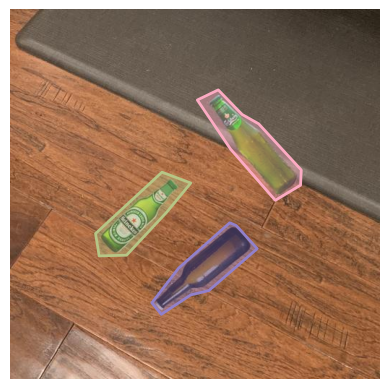

In [40]:
# второй вариант полигон - маска
from skimage import data
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
dataDir='images2'
annFile='{}/annotations/1/12.json'.format(dataDir)


coco=COCO(annFile)
annFile = '{}/annotations/2test/12.json'.format(dataDir)
coco_kps=COCO(annFile)


catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = imgIds[0])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('images2/annotations/1/'+img['file_name'])

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


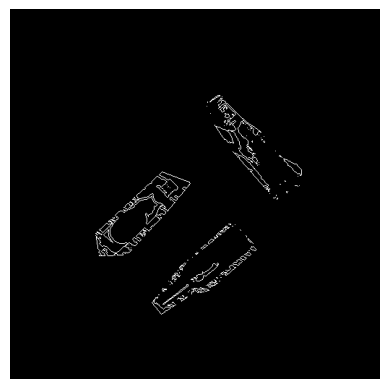

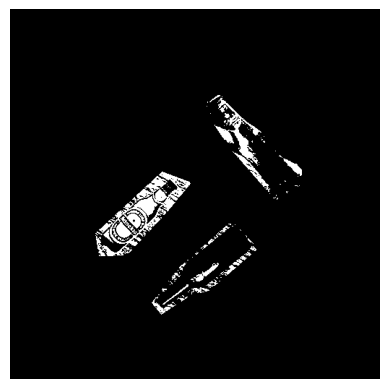

True

In [101]:
#простой вариант
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

dataDir='images2'
annFile='{}/annotations/1/12.json'.format(dataDir)
image = cv2.imread('images2/annotations/1/000.jpg', cv2.IMREAD_GRAYSCALE)

coco = COCO(annFile)
imgIds = coco.getImgIds()
imgId = imgIds[0]
img = coco.loadImgs(imgId)[0]
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)

width, height = img['width'], img['height']
mask = np.zeros((height, width), dtype=np.uint8)

for ann in anns:
    if 'segmentation' in ann:
        for seg in ann['segmentation']:
            cv2.fillPoly(mask, [np.array(seg).reshape((-1, 1, 2)).astype(np.int32)], color=1)

bitwiseAnd = cv2.bitwise_and(image,image,mask=mask)
blurred = cv2.GaussianBlur(bitwiseAnd, (3, 3), 0)
T, thresh_img = cv2.threshold(bitwiseAnd, 112, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)

plt.imshow(img_contours, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(thresh_img, cmap='gray')
plt.axis('off')
plt.show()

# cv2.imwrite('images2/annotations/1/mask2.png', img_contours)  



loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


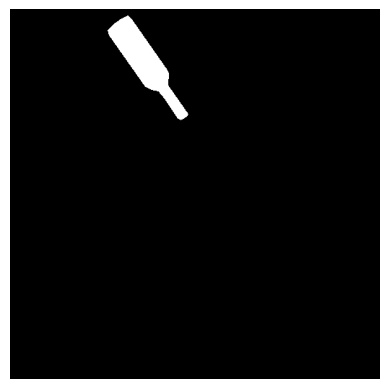

: 

In [56]:
#простой вариант (пробую готовые аннотации)
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

dataDir='images2'
annFile='{}/annotations/test/coco_instances.json'.format(dataDir)
image = cv2.imread('images2/annotations/1/000.jpg', cv2.IMREAD_GRAYSCALE)

coco = COCO(annFile)
imgIds = coco.getImgIds()
imgId = imgIds
img = coco.loadImgs(imgId)[0]
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)


width, height = img['width'], img['height']

for ann in anns:
    if 'segmentation' in ann:
        for seg in ann['segmentation']:
            mask = np.zeros((height, width), dtype=np.uint8)
            cv2.fillPoly(mask, [np.array(seg).reshape((-1, 1, 2)).astype(np.int32)], color=255)
        cv2.imwrite(f'images2/annotations/test/mask2{seg[0]}.png', mask)
        
          
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()



# bitwiseAnd = cv2.bitwise_and(image,image,mask=mask)
# blurred = cv2.GaussianBlur(bitwiseAnd, (3, 3), 0)
# T, thresh_img = cv2.threshold(bitwiseAnd, 112, 255, cv2.THRESH_BINARY)
# contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))
# cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)

# plt.imshow(img_contours, cmap='gray')
# plt.axis('off')
# plt.show()
# plt.imshow(thresh_img, cmap='gray')
# plt.axis('off')
# plt.show()

In [10]:
#простой вариант (пробую разом все аннотации сохранить в маски (Получилось каким то образом))
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

dataDir='images2'
annFile='{}/annotations/test/coco_instances.json'.format(dataDir)
image = cv2.imread('images2/annotations/1/000.jpg', cv2.IMREAD_GRAYSCALE)

coco = COCO(annFile)
imgIds = coco.getImgIds()
imgId = imgIds[:4]
img = coco.loadImgs(imgId)[0]
width, height = img['width'], img['height']
mask = np.zeros((height, width), dtype=np.uint8)
for imgId in imgIds:
    annIds = coco.getAnnIds(imgIds=imgId)
    anns = coco.loadAnns(annIds)
    for ann in anns:
        if 'segmentation' in ann:
            for seg in ann['segmentation']:
                cv2.fillPoly(mask, [np.array(seg).reshape((-1, 1, 2)).astype(np.int32)], color=1)
                cv2.imwrite(f'images2/annotations/test/mask2{seg[0]}.png', mask)
                ann.pop('segmentation')
                



# print(anns)
# plt.imshow(mask, cmap='gray') 
# plt.axis('off')
# plt.show()

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


KeyError: 'segmentation'

Модель U2-Net успешно загружена!


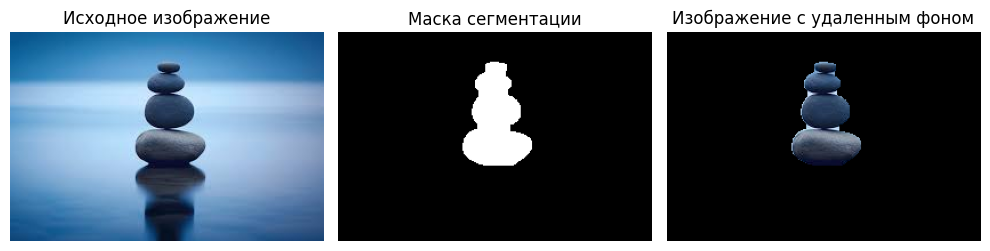

In [68]:
# Работающая модель по удалению фона на основе u2net
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision.transforms as transforms
from PIL import Image
import cv2  
import numpy as np
import matplotlib.pyplot as plt 

try:
    from u2net.model.u2net import U2NET
except ImportError:
    print("Ошибка: Не удалось импортировать U2-Net.  Проверьте, что вы правильно установили библиотеку и указали путь к ней.")
    exit()  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "u2net/saved_models/u2net/u2net.pth" 

try:
    model = U2NET(3, 1) 
    model.load_state_dict(torch.load(model_path, map_location=device)) 
    model.to(device)
    model.eval()
    print("Модель U2-Net успешно загружена!")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")
    exit()


# Загрузка и предобработка изображения
def preprocess_image(image_path, device):
    try:
        image = Image.open(image_path).convert("RGB")  
    except FileNotFoundError:
        print(f"Ошибка: Изображение по пути '{image_path}' не найдено.")
        return None
    except Exception as e:
        print(f"Ошибка при открытии изображения: {e}")
        return None

    transform = transforms.Compose([
        # transforms.Resize((320, 320)),  # Измените размер в соответствии с требованиями модели
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    image = transform(image).unsqueeze(0)  # Добавление размерности batch (Переводит из (RGB, H, W) в (количество изображений, RGB, H, W))
    return image.to(device) 

# Выполнение сегментации
def perform_segmentation(image_path, model, device):
    input_image = preprocess_image(image_path, device)
    if input_image is None:
        return None

    with torch.no_grad():
        output = model(input_image) # Прямой проход через модель
        
        output = output[0]
        output = output[0, 0, :, :]
        output = output.cpu().numpy()

        # numpy_arrays = []
        # for i, tensor in enumerate(output):
        #     try:
        #         extracted_tensor = tensor[0, 0, :, :]
        #         numpy_array = extracted_tensor.cpu().numpy()
        #         numpy_arrays.append(numpy_array)
        #     except IndexError as e:
        #         print(f"Ошибка индексации для тензора {i}: {e}.  Пропустили этот тензор.")
        #         continue
        # # numpy_arrays = torch.sigmoid(numpy_arrays) #Применение сигмоида (если выход - логиты)
        

    # return numpy_arrays
    return output

# Обработка результата (удаление фона)
def process_segmentation_mask(mask, image_path, threshold=0.5):
    try:
        image = cv2.imread(image_path) # Чтение изображения с помощью OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование в RGB

        # Применение порогового значения для создания бинарной маски
        mask = (mask > threshold).astype(np.uint8) * 255  # Получение бинарной маски (0 или 255)
        # Улучшение маски 
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) 

        # Применение маски к изображению (удаление фона)
        masked_image = np.zeros(image.shape, dtype=np.uint8) #  Создание пустого массива для результата
        for c in range(3):
            masked_image[:, :, c] = image[:, :, c] * (mask / 255)  # Применение маски
    except Exception as e:
        print(f"Ошибка при обработке маски: {e}")
        return None

    return masked_image, mask

# Пример использования
if __name__ == "__main__":
    image_path = "images2/003.jpeg" 
    segmentation_result = perform_segmentation(image_path, model, device)

    if segmentation_result is not None:
        masked_image, mask = process_segmentation_mask(segmentation_result, image_path)

        
        if masked_image is not None:
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 3, 1)
            plt.axis('off')
            plt.imshow(Image.open(image_path))
            plt.title("Исходное изображение")

            plt.subplot(1, 3, 2)
            plt.axis('off')
            plt.imshow(mask, cmap='gray')
            plt.title("Маска сегментации")

            plt.subplot(1, 3, 3)
            plt.axis('off')
            plt.imshow(masked_image)
            plt.title("Изображение с удаленным фоном")

            plt.tight_layout()
            plt.show()

        else:
            print("Не удалось обработать маску.")
    else:
        print("Не удалось выполнить сегментацию.")
        